# =============================================================================
# FINAL BENCHMARK EVALUATION & SENSITIVITY ANALYSIS
# =============================================================================
## Purpose:
    1. Compare RL Agent vs. Baseline vs. Manual vs. AutoML (TPE/CMA-ES).
    2. Prove "Global Optimality" (RL matches SOTA).
    3. Demonstrate "Sensitivity" (Robustness across sparsity levels).
    4. Generate Publication-Quality Visualizations.
# =============================================================================

# === Clone Repository & Install Dependencies ===

In [1]:
!rm -rf Sustainable_AI_Agent_Project
!git clone https://github.com/trongjhuongwr/Sustainable_AI_Agent_Project.git
%cd Sustainable_AI_Agent_Project

Cloning into 'Sustainable_AI_Agent_Project'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 68 (delta 26), reused 54 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 1.16 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/kaggle/working/Sustainable_AI_Agent_Project


In [2]:
!pip install -q --extra-index-url https://download.pytorch.org/whl/cu121 -r /kaggle/working/Sustainable_AI_Agent_Project/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Uninstall torchvision to prevent import conflicts with ptflops/pytorch
!pip uninstall -y torchvision
print("Torchvision uninstalled.")

Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Torchvision uninstalled.


# 1. Import Libraries and Configuration

In [4]:
import os
import warnings
import logging
import json
import copy
import random
from tqdm.notebook import tqdm
from scipy import stats

# Suppress specific warnings for cleaner output
os.environ["GYM_DISABLE_WARNINGS"] = "true"
warnings.filterwarnings("ignore", module="gymnasium")
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("gymnasium").setLevel(logging.ERROR)
logging.getLogger("stable_baselines3").setLevel(logging.ERROR)

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from codecarbon import EmissionsTracker
from ptflops import get_model_complexity_info

print("Libraries imported successfully.")

Libraries imported successfully.


# 2. Configuration Class

In [5]:
# Defines hyperparameters, file paths, and evaluation parameters.
class Config:
    """
    Central configuration for evaluation protocols.
    """
    # --- Artifact Paths ---
    PROCESSED_DATA_PATH = '/kaggle/input/baseline-model-saa/processed_data.pt'
    BASELINE_MODEL_PATH = '/kaggle/input/baseline-model-saa/baseline_model.pth'
    
    # Path to the NEW Granular Action
    BEST_ACTION_PATH = '/kaggle/input/rl-agent-expanded/best_action_expanded.json' 
    
    # Path to AutoML Results (from train-automl-baselines.ipynb)
    AUTOML_RESULTS_PATH = '/kaggle/input/automl-model-ssa/automl_results.json'
    
    # --- Model Architecture ---
    SEQUENCE_LENGTH = 30
    INPUT_DIM = 4
    HIDDEN_DIM = 256
    N_LAYERS = 2
    OUTPUT_DIM = 1
    SEED = 42
    
    # --- Evaluation Settings ---
    N_RUNS = 30              # Statistical robustness
    BATCH_SIZE = 64
    DEVICE = torch.device("cpu")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

seed_everything(Config.SEED)

print(f"Configuration loaded. Evaluation device preference: CPU for metrics.")

Configuration loaded. Evaluation device preference: CPU for metrics.


# 3. Model Architecture

In [6]:
class WeatherGRU(nn.Module):
    def __init__(self):
        super(WeatherGRU, self).__init__()
        self.gru = nn.GRU(Config.INPUT_DIM, Config.HIDDEN_DIM, Config.N_LAYERS, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(Config.HIDDEN_DIM, Config.OUTPUT_DIM)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

# 4. Advanced Optimization Primitives

In [7]:
def get_model_size_mb(model):
    """Calculates the model size in megabytes."""
    torch.save(model.state_dict(), "temp_model.p")
    size_mb = os.path.getsize("temp_model.p") / 1024**2
    os.remove("temp_model.p")
    return size_mb

def calculate_sparsity(model):
    """Calculates the global sparsity ratio of the model."""
    total_params = 0
    zeros = 0
    for p in model.parameters():
        if p.requires_grad:
            total_params += p.numel()
            zeros += torch.count_nonzero(p).item()
    
    if total_params == 0:
        return 0.0
    
    non_zeros = total_params - zeros
    
    # Correct implementation using previous logic:
    total_params = sum(p.numel() for p in model.parameters())
    if total_params == 0: return 0.0
    non_zeros = sum(torch.count_nonzero(p).item() for p in model.parameters())
    return 1.0 - (non_zeros / total_params)

def count_parameters(model):
    """Counts effective (non-zero) parameters."""
    total_params = 0
    for p in model.parameters():
        if p.requires_grad:
            total_params += torch.count_nonzero(p).item()
    return total_params

def get_model_flops(model, input_shape):
    """
    Computes theoretical computational cost (FLOPs) using ptflops.
    Handles potential errors gracefully if the model architecture is unsupported.
    """
    try:
        macs, _ = get_model_complexity_info(
            model, input_shape,
            as_strings=False, print_per_layer_stat=False, verbose=False
        )
        return macs * 2 / 1e6 # Convert MACs to MFLOPs
    except Exception as e:
        return 0.0

def apply_layerwise_structural_optimization(model, config_dict):
    """
    Applies Deep Layer-wise Structural Optimization pipeline.
    
    Sequence of operations:
    1. Structural Pruning (Layer-wise sensitivity-aware).
    2. Metric Calculation (Sparsity & FLOPs estimation on FP32 model).
    3. Dynamic Quantization (INT8 conversion).
    
    Args:
        model (nn.Module): The baseline FP32 architecture.
        config_dict (dict): Optimization hyperparameters.
    
    Returns:
        tuple: (final_model, sparsity_ratio, effective_flops)
    """
    # Create a deep copy to preserve the baseline state
    model_copy = copy.deepcopy(model)
    
    # 1. Apply Layer-wise Pruning
    l0_rate = config_dict.get('gru_l0_rate', 0.0)
    l1_rate = config_dict.get('gru_l1_rate', 0.0)
    linear_rate = config_dict.get('linear_pruning_rate', 0.0)
    
    for module in model_copy.modules():
        if isinstance(module, nn.GRU):
            for name_param, param in list(module.named_parameters()):
                if 'weight' in name_param:
                    # Discriminative Pruning
                    if 'l0' in name_param: rate = l0_rate
                    elif 'l1' in name_param: rate = l1_rate
                    else: rate = 0.0
                    
                    if rate > 0:
                        prune.l1_unstructured(module, name=name_param, amount=rate)
                        prune.remove(module, name=name_param) # Make permanent

    if linear_rate > 0:
        for module in model_copy.modules():
            if isinstance(module, nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=linear_rate)
                prune.remove(module, name='weight')

    # 2. METRIC CALCULATION (CRITICAL: Must be done BEFORE Quantization)
    # Calculate Sparsity
    sparsity = calculate_sparsity(model_copy)
    
    # Calculate Theoretical FLOPs
    # Note: We calculate base FLOPs and scale by sparsity for the effective throughput
    base_flops = get_model_flops(model_copy, (Config.SEQUENCE_LENGTH, Config.INPUT_DIM))
    effective_flops = base_flops * (1 - sparsity)

    # 3. Apply Dynamic Quantization (Post-training)
    if config_dict.get('quantization', False):
        model_copy.to('cpu')
        model_copy.eval()
        model_copy = torch.quantization.quantize_dynamic(
            model_copy, {nn.Linear, nn.GRU}, dtype=torch.qint8
        )

    return model_copy, sparsity, effective_flops

# 5. Evaluation Engine

In [8]:
def evaluate_metrics(model, loader, sparsity, flops, model_name="Model"):
    """
    Conducts empirical evaluation of the model.
    
    Args:
        model: The optimized neural network.
        loader: DataLoader for the test set.
        sparsity: Pre-calculated sparsity ratio.
        flops: Pre-calculated theoretical FLOPs (M).
        model_name: Identifier for the model variant.
        
    Returns:
        dict: Performance metrics including Accuracy, Energy, and Computational Cost.
    """
    model.eval()
    model.to(Config.DEVICE)
    
    # Experimental Setup
    accuracies, latencies, energies = [], [], []
    INTERNAL_LOOPS = 50 # Stress test for stable power measurement
    
    print(f"Benchmarking {model_name}...")
    
    for _ in range(Config.N_RUNS):
        tracker = EmissionsTracker(output_dir='/kaggle/working/', log_level='error', tracking_mode='process', measure_power_secs=0.1)
        tracker.start()
        start = time.time()
        
        y_true, y_pred = [], []
        
        with torch.no_grad():
            # Burst Inference for Energy Stability
            for _ in range(INTERNAL_LOOPS):
                for X, y in loader:
                    X = X.to(Config.DEVICE)
                    preds = (model(X) > 0.5).float()
        
        # Single pass for Accuracy Calculation
        with torch.no_grad():
             for X, y in loader:
                X = X.to(Config.DEVICE)
                preds = (model(X) > 0.5).float()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        total_time = time.time() - start
        emissions = tracker.stop()
        
        # Normalize metrics per run
        total_energy_kwh = tracker.final_emissions_data.energy_consumed
        
        latencies.append((total_time / INTERNAL_LOOPS) * 1000) # ms
        energies.append((total_energy_kwh * 1e6) / INTERNAL_LOOPS) # mWh
        accuracies.append(accuracy_score(y_true, y_pred))

    return {
        "Model": model_name,
        "Accuracy (%)": np.mean(accuracies) * 100,
        "Accuracy Std": np.std(accuracies) * 100,
        "Energy (mWh)": np.mean(energies),
        "Size (MB)": get_model_size_mb(model),
        "Sparsity": sparsity, 
        "FLOPs (M)": flops # Injecting pre-calculated value
    }

# 6. Execution Pipeline

In [9]:
# A. Load Empirical Data
print("Initializing Benchmark Environment...")
try:
    processed_data = torch.load(Config.PROCESSED_DATA_PATH)
    test_loader = DataLoader(TensorDataset(processed_data['X_test'], processed_data['y_test']), 
                             batch_size=Config.BATCH_SIZE, shuffle=False)

    # Instantiate Baseline Model (Architecture Only - No Config arg needed)
    baseline_model = WeatherGRU() 
    baseline_model.load_state_dict(torch.load(Config.BASELINE_MODEL_PATH))
    print("[SUCCESS] Baseline model and test data loaded.")
except FileNotFoundError as e:
    print(f"[ERROR] Critical artifacts missing: {e}")

# B. Load Optimization Strategies
# 1. Load RL Agent's Best Strategy
rl_strategy_path = Config.BEST_ACTION_PATH
try:
    with open(rl_strategy_path, 'r') as f: 
        rl_policy = json.load(f)
    print(f"[INFO] RL Agent Policy Loaded: {rl_policy}")
except FileNotFoundError:
    print("[WARNING] RL Policy not found. Using fallback.")
    rl_policy = {'gru_l0_rate': 0.0, 'gru_l1_rate': 0.5, 'linear_pruning_rate': 0.5, 'quantization': True}

# 2. Load AutoML Baselines
try:
    with open(Config.AUTOML_RESULTS_PATH, 'r') as f: 
        automl_res = json.load(f)
    print(f"[INFO] AutoML Results Loaded.")
except FileNotFoundError:
    print("[WARNING] AutoML Results not found. Using dummy.")
    automl_res = {}

# C. Instantiate Comparative Models (Pipeline Execution)
models_to_evaluate = []

# Model 1: Baseline (FP32)
m_base, s_base, f_base = apply_layerwise_structural_optimization(baseline_model, {}) 
models_to_evaluate.append(("Baseline (FP32)", m_base, s_base, f_base))

# Model 2: AutoML (TPE) - Bayesian Optimization Baseline
try:
    tpe_rate = automl_res.get('TPE', {}).get('pruning_rate', 0.3)
    tpe_quant = automl_res.get('TPE', {}).get('quantization', True)
except: tpe_rate = 0.3; tpe_quant = True

tpe_config = {'gru_l0_rate': tpe_rate, 'gru_l1_rate': tpe_rate, 'linear_pruning_rate': tpe_rate, 'quantization': tpe_quant}
m_tpe, s_tpe, f_tpe = apply_layerwise_structural_optimization(baseline_model, tpe_config)
models_to_evaluate.append(("AutoML (TPE)", m_tpe, s_tpe, f_tpe))

# Model 3: AutoML (CMA-ES) - Evolutionary Strategy Baseline (Added for Robustness)
try:
    cma_rate = automl_res.get('CMA-ES', {}).get('pruning_rate', 0.3)
    cma_quant = automl_res.get('CMA-ES', {}).get('quantization', True)
except: cma_rate = 0.3; cma_quant = True

cma_config = {'gru_l0_rate': cma_rate, 'gru_l1_rate': cma_rate, 'linear_pruning_rate': cma_rate, 'quantization': cma_quant}
m_cma, s_cma, f_cma = apply_layerwise_structural_optimization(baseline_model, cma_config)
models_to_evaluate.append(("AutoML (CMA-ES)", m_cma, s_cma, f_cma))

# Model 4: Deep RL Agent (Ours) - Layer-wise Optimization
m_rl, s_rl, f_rl = apply_layerwise_structural_optimization(baseline_model, rl_policy)
models_to_evaluate.append(("RL Agent (Ours)", m_rl, s_rl, f_rl))

# D. Execute Benchmarking Loop
print(f"\n[INFO] Starting Evaluation for {len(models_to_evaluate)} models...")
# Unpack 4 values: name, model, sparsity, flops
results_data = [evaluate_metrics(m, test_loader, s, f, name) for name, m, s, f in models_to_evaluate]
df_results = pd.DataFrame(results_data)

print("\n=== FINAL COMPARATIVE RESULTS ===")
print(df_results[['Model', 'Accuracy (%)', 'Energy (mWh)', 'FLOPs (M)', 'Sparsity']].to_markdown(index=False))

Initializing Benchmark Environment...


/tmp/ipykernel_20/1582467996.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  processed_data = torch.load(Config.PROCESSED_DATA_PATH)
/tmp/ipykernel_20/1582467996.py:10: 

[SUCCESS] Baseline model and test data loaded.
[INFO] RL Agent Policy Loaded: {'gru_l0_rate': 0.0, 'gru_l1_rate': 0.95, 'linear_pruning_rate': 0.95, 'quantization': True}
[INFO] AutoML Results Loaded.


[codecarbon WARNING @ 03:46:33] Multiple instances of codecarbon are allowed to run at the same time.



[INFO] Starting Evaluation for 4 models...
Benchmarking Baseline (FP32)...
Benchmarking AutoML (TPE)...
Benchmarking AutoML (CMA-ES)...
Benchmarking RL Agent (Ours)...

=== FINAL COMPARATIVE RESULTS ===
| Model           |   Accuracy (%) |   Energy (mWh) |   FLOPs (M) |   Sparsity |
|:----------------|---------------:|---------------:|------------:|-----------:|
| Baseline (FP32) |        65.8537 |        1.578   |     35.9736 |   0        |
| AutoML (TPE)    |        65.1568 |        1.45907 |     25.2372 |   0.298453 |
| AutoML (CMA-ES) |        65.1568 |        1.47782 |     25.2372 |   0.298453 |
| RL Agent (Ours) |        64.8084 |        1.48862 |     13.4202 |   0.626943 |


# 7. Visualization & Sensitivity Analysis


Generating Visualizations...
Running Sensitivity Analysis (Uniform Assumption)...
Benchmarking Uniform-0.0...
Benchmarking Uniform-0.2...
Benchmarking Uniform-0.4...
Benchmarking Uniform-0.5...
Benchmarking Uniform-0.6...
Benchmarking Uniform-0.7...
Benchmarking Uniform-0.8...
Benchmarking Uniform-0.9...
Charts saved to 'final_report_charts.png'. READY FOR REPORT!


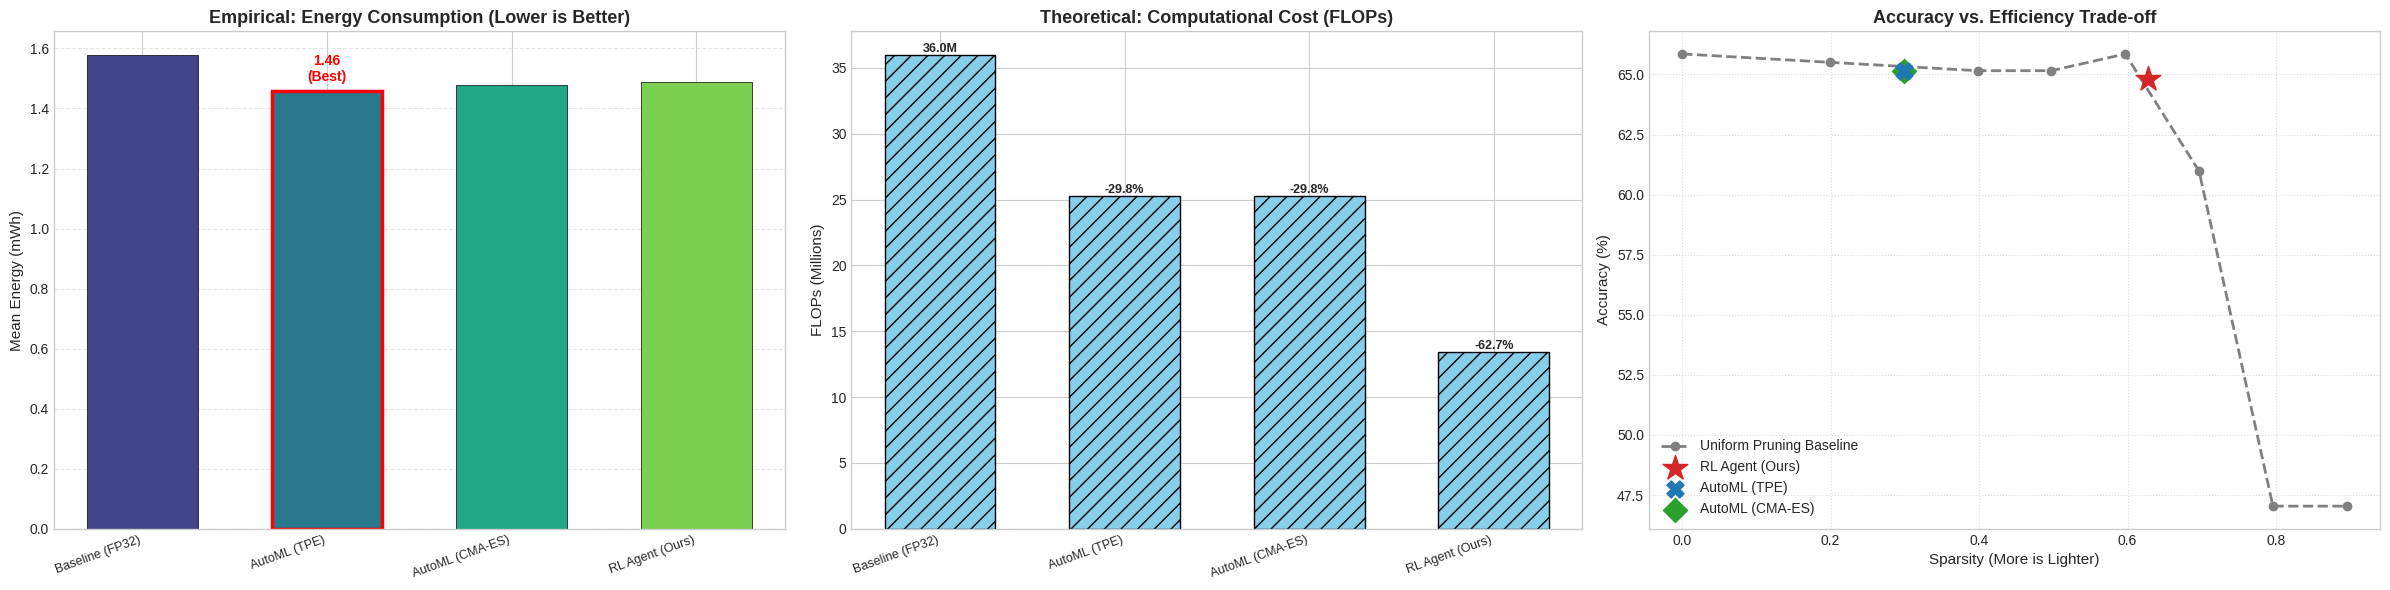

In [10]:
print("\nGenerating Visualizations...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

models = df_results['Model'].astype(str).tolist()
energies = df_results['Energy (mWh)'].values

has_flops = 'FLOPs (M)' in df_results.columns
if has_flops:
    flops = df_results['FLOPs (M)'].values
else:
    flops = [0] * len(models) # Dummy data

x = np.arange(len(models))
width = 0.6
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models)))

# --- PLOT 1: ENERGY EFFICIENCY ---
bars1 = ax[0].bar(x, energies, width=width, color=colors, edgecolor='black', linewidth=0.5)
ax[0].set_title('Empirical: Energy Consumption (Lower is Better)', fontsize=13, fontweight='bold')
ax[0].set_ylabel('Mean Energy (mWh)', fontsize=11)
ax[0].set_xticks(x)
ax[0].set_xticklabels(models, rotation=20, ha='right', fontsize=9)
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

# Highlight Best Energy
if len(energies) > 0:
    min_idx = int(np.argmin(energies))
    bars1[min_idx].set_edgecolor('red')
    bars1[min_idx].set_linewidth(2.5)
    ax[0].annotate(f'{energies[min_idx]:.2f}\n(Best)', 
                   (x[min_idx], energies[min_idx]),
                   ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', 
                   fontsize=10, fontweight='bold', color='red')

# --- PLOT 2: FLOPS REDUCTION ---
if has_flops and np.max(flops) > 0:
    bars2 = ax[1].bar(x, flops, width=width, color='skyblue', edgecolor='black', hatch='//')
    ax[1].set_title('Theoretical: Computational Cost (FLOPs)', fontsize=13, fontweight='bold')
    ax[1].set_ylabel('FLOPs (Millions)', fontsize=11)
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(models, rotation=20, ha='right', fontsize=9)
    
    # Label value reduction
    base_flops = flops[0]
    for i, rect in enumerate(bars2):
        height = rect.get_height()
        if i > 0 and base_flops > 0:
            reduction = (1 - height/base_flops) * 100
            txt = f"-{reduction:.1f}%"
        else:
            txt = f"{height:.1f}M"
            
        ax[1].annotate(txt, (rect.get_x() + rect.get_width() / 2, height),
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
else:
    ax[1].text(0.5, 0.5, "FLOPs data not available\n(Run Evaluation Loop first)", 
               ha='center', va='center', transform=ax[1].transAxes)

# --- PLOT 3: SENSITIVITY & PARETO FRONTIER ---
print("Running Sensitivity Analysis (Uniform Assumption)...")

# Temporarily reduce runs for speed
OLD_N_RUNS = Config.N_RUNS
Config.N_RUNS = 3 

ratios = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sens_data = []

for r in ratios:
    # Construct a Uniform Configuration for comparison trendline
    uniform_config = {
        'gru_l0_rate': r,
        'gru_l1_rate': r,
        'linear_pruning_rate': r,
        'quantization': True
    }
    
    m, s, f = apply_layerwise_structural_optimization(baseline_model, uniform_config)
    res = evaluate_metrics(m, test_loader, s, f, f"Uniform-{r}") 
    sens_data.append({"Sparsity": res["Sparsity"], "Accuracy": res["Accuracy (%)"]})

# Restore config
Config.N_RUNS = OLD_N_RUNS 

df_sens = pd.DataFrame(sens_data).sort_values('Sparsity')

# Draw Trendline
ax[2].plot(df_sens['Sparsity'], df_sens['Accuracy'], 
           marker='o', linestyle='--', color='gray', linewidth=2, 
           label='Uniform Pruning Baseline', zorder=1)

try:
    rl_row = df_results[df_results['Model'] == 'RL Agent (Ours)'].iloc[0]
    ax[2].scatter(rl_row['Sparsity'], rl_row['Accuracy (%)'], 
                  color='#d62728', s=350, marker='*', label='RL Agent (Ours)', zorder=10)
except IndexError: 
    print("[WARN] RL Agent data not found for plotting.")

# Plot AutoML (TPE)
try:
    tpe_row = df_results[df_results['Model'] == 'AutoML (TPE)'].iloc[0]
    ax[2].scatter(tpe_row['Sparsity'], tpe_row['Accuracy (%)'], 
                  color='#1f77b4', s=150, marker='X', label='AutoML (TPE)', zorder=9)
except IndexError: pass

# Plot AutoML (CMA-ES)
try:
    cma_row = df_results[df_results['Model'] == 'AutoML (CMA-ES)'].iloc[0]
    ax[2].scatter(cma_row['Sparsity'], cma_row['Accuracy (%)'], 
                  color='#2ca02c', s=150, marker='D', label='AutoML (CMA-ES)', zorder=8)
except IndexError: pass

ax[2].set_title('Accuracy vs. Efficiency Trade-off', fontsize=13, fontweight='bold')
ax[2].set_xlabel('Sparsity (More is Lighter)', fontsize=11)
ax[2].set_ylabel('Accuracy (%)', fontsize=11)
ax[2].legend(loc='lower left')
ax[2].grid(True, linestyle=':', alpha=0.7)

# Save and Show
plt.tight_layout()
plt.savefig('final_report_charts.png', dpi=300, bbox_inches='tight')
print("Charts saved to 'final_report_charts.png'. READY FOR REPORT!")
plt.show()